<a href="https://colab.research.google.com/github/hvega6/upscale/blob/main/Stability_API_Image_Upscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stability API - Image Upscaling

**In this notebook we're going to go over how to set up the Stability SDK package, and how to use our API to perform an image upscaling call.**

In [ ]:
#@title <a name="Step 1"><font color="#FFFFFF">1. Install the Stability SDK package.</font></a>

%pip install stability-sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 35.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
#@title <a name="Step 2"><font color="#FFFFFF">2. Set up our environment variables and API Key.</font></a>

import getpass, os

# Our Host URL should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://dreamstudio.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://dreamstudio.ai/account

# Paste your API Key below after running this cell.

os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

Enter your API Key··········


In [ ]:
#@title <a name="Step 3"><font color="#FFFFFF">3. Import additional dependencies and establish our connection to the API.</font></a>

import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    upscale_engine="esrgan-v1-x2plus", # The name of the upscaling model we want to use.
                                       # Available Upscaling Engines: esrgan-v1-x2plus, stable-diffusion-x4-latent-upscaler
    verbose=True, # Print debug messages.
)

INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


# Parameter Considerations

Depending on the engine that is in use `stability_api.upscale` accepts different parameters.

If `esrgan-v1-x2plus` is in use, `init_image=` `width=` and `height=` parameters are accepted.

If `stable-diffusion-x4-latent-upscaler` is in use the additional parameters of `seed=` `steps=` `cfg_scale=` and `prompt=` are accepted. These additional parameters will be ignored if passed to `esrgan-v1-x2plus`.

Note that only `width=` **OR** `height=` can be passed to the upscale function to specify the desired output size, never both. If no `width=` or `height=` parameter is provided, the image will be upscaled to `2x` or `4x` its dimensions by default depending on the engine in use. Providing, for example `width=1024`, will upscale the image to `1024` pixels wide, and automatically account for the height in order to maintain the initial image's aspect ratio.

If upscaling an image that was originally generated via one of our inference engines with `stable-diffusion-x4-latent-upscaler`, best practice is to use the same prompt and seed as the original generation call as this helps with the quality of the resulting image.

# Limits

Input / output images can be any aspect ratio, however certain pixel counts must be obeyed depending on the engine in use.  

| Model                               | Input Image Limit (pixels) | Equivalent Input Image (dimensions) | Output Image Limit (pixels)   | Equivalent Output Image (dimensions)   |
| ------------------------------------|----------------------------|-------------------------------------|-------------------------------|----------------------------------------|
| esrgan-v1-x2plus                    | 1048576                    | 1024 x 1024                         | 4194304                       | 2048 x 2048                            |
| stable-diffusion-x4-latent-upscaler | 393216                     | 512 x 768                           | 6291456                       | 2048 x 3072                            |

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive a53f34a1-be71-4eba-af2a-3c954d3ccfcb in 0.34s
INFO:stability_sdk.client:Got keepalive a53f34a1-be71-4eba-af2a-3c954d3ccfcb in 0.29s
INFO:stability_sdk.client:Got answer a53f34a1-be71-4eba-af2a-3c954d3ccfcb with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.25s


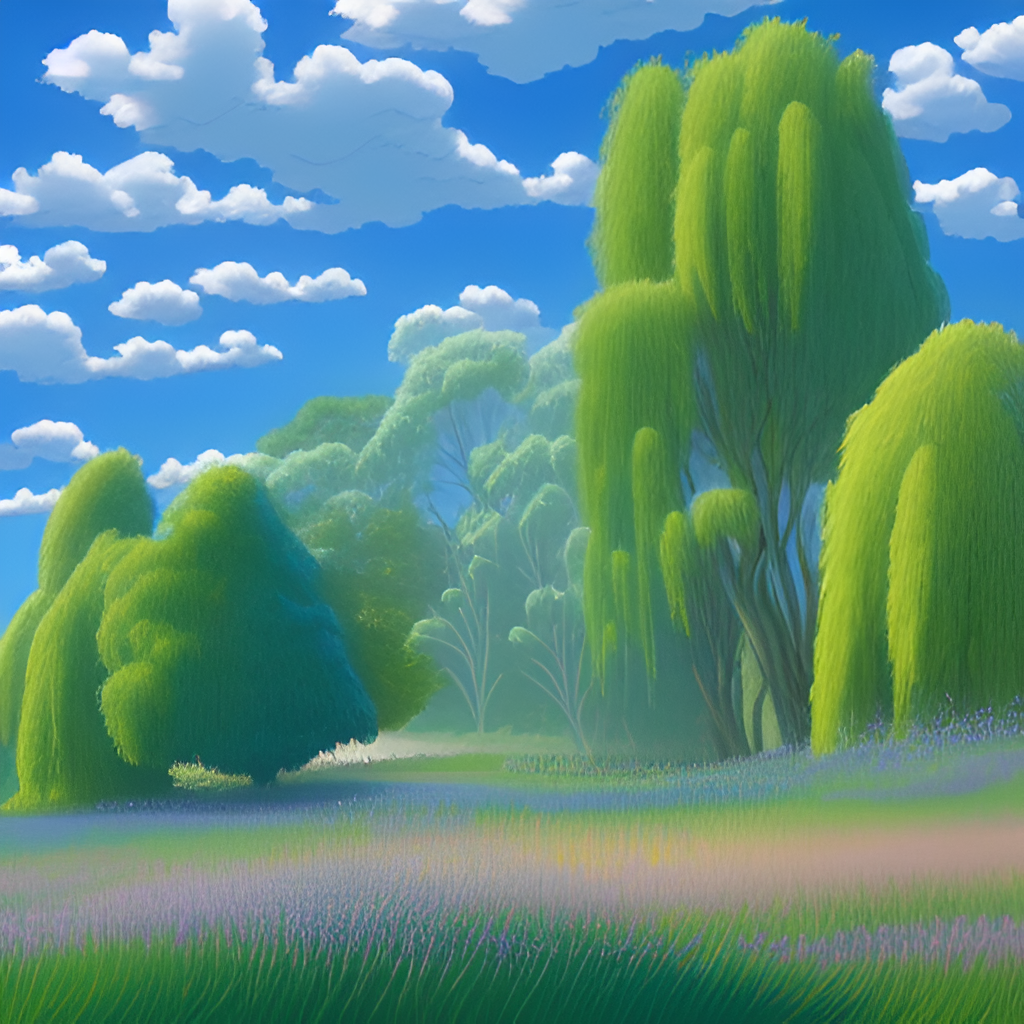

In [ ]:
#@title <a name="Step 4"><font color="#FFFFFF">4. Set up initial parameters, display image on completion of upscaling, and set up safety warning for if the adult content classifier is tripped.</font></a>

# Import our local image to use as a reference for our upscaled image.
# Imported images can be any aspect ratio, as long as they do not contain over 1048576 pixels (this can be related to the total pixels in a 1024 x 1024 image) in total.
# The 'img' variable below is set to a local file for upscaling, however if you are already running a generation call and have an image artifact available, you can pass that image artifact to the upscale function instead.
img = Image.open('/content/img2upscale.png')

answers = stability_api.upscale(
    init_image=img, # Pass our image to the API and call the upscaling process.
    # width=1024, # Optional parameter to specify the desired output width.
    # prompt="A beautiful sunset", # Optional parameter when using `stable-diffusion-x4-latent-upscaler` to specify a prompt to use for the upscaling process.
    # seed=1234, # Optional parameter when using `stable-diffusion-x4-latent-upscaler` to specify a seed to use for the upscaling process.
    # steps=20, # Optional parameter when using `stable-diffusion-x4-latent-upscaler` to specify the number of diffusion steps to use for the upscaling process. Defaults to 20 if no value is passed, with a maximum of 50.
    # cfg_scale=7 # Optional parameter when using `stable-diffusion-x4-latent-upscaler` to specify the strength of prompt in use for the upscaling process. Defaults to 7 if no value is passed.
)

# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, save our image.

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please submit a different image and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            big_img = Image.open(io.BytesIO(artifact.binary))
            display(big_img)